# TikTok Hackathon Challenge 2023

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.evaluator import Evaluator
from pymoo.decomposition.asf import ASF

In [4]:
df_ads = pd.read_csv('../preprocessing/preprocessed_ads.csv')
df_moderator_clean = pd.read_csv('../preprocessing/preprocessed_moderator_clean.csv')
df_moderator_anomaly = pd.read_csv('../preprocessing/preprocessed_moderator_anomaly.csv')

## Scoring Functions

We propose a weighted system to score the advertisements and moderators. These weights will be our decision variables in the optimisation process


$\text{ad score} = w_1 \times \text{punish num} + w_2 \times \text{avg ad revenue}$

$\text{moderator score} = v_1 \times \frac{1}{\text{handling time}} + v_2 \times \text{accuracy}$

$\text{where } w_1 + w_2 = 1 \text{ and } v_1 + v_2 = 1$


In [5]:
def ad_scoring(data, w1, w2):
    data['ad_score'] = w1 * data['scaled_punish_num'] + w2 * data['scaled_avg_ad_revenue']
    data_sorted = data.sort_values(by='ad_score', ascending=False)
    return data_sorted

def moderator_scoring(data, v1, v2):
    data['moderator_score'] = v1 * data['scaled_reciprocal_handling_time'] + v2 * data['accuracy']
    data_sorted = data.sort_values(by='moderator_score', ascending=False)
    return data_sorted

Testing the functions

In [6]:
df_ranked_ads = ad_scoring(df_ads, 0.5, 0.5)
df_ranked_ads

,ad_id,delivery_country,punish_num,avg_ad_revenue,scaled_punish_num,scaled_avg_ad_revenue,ad_score
11,1765089254920220,JP,16.0,23.7129,1.0,0.001383,0.500692
10,1764585402541070,JP,16.0,23.7129,1.0,0.001383,0.500692
16,1767664297196540,JP,16.0,23.7129,1.0,0.001383,0.500692
15,1767664297198600,JP,16.0,23.7129,1.0,0.001383,0.500692
12,1765121170665500,JP,16.0,23.7129,1.0,0.001383,0.500692
...,...,...,...,...,...,...,...
23408,1773545644180480,MY,0.0,0.0000,0.0,0.000000,0.000000
26440,1773564116748290,NL,0.0,0.0000,0.0,0.000000,0.000000
18990,1773528822210560,AR,0.0,0.0000,0.0,0.000000,0.000000
26432,1773486190435320,AE,0.0,0.0000,0.0,0.000000,0.000000


In [7]:
df_ranked_moderators_clean = moderator_scoring(df_moderator_clean, 0.5, 0.5)
df_ranked_moderators_clean

,moderator,Productivity,Utilisation %,handling time,reciprocal_handling_time,scaled_reciprocal_handling_time,accuracy,BH,RO,TW,...,CH,AT,KH,HR,IE,LV,US,SG,NL,moderator_score
806,1695311101589506,2.2800,1.045104,104,0.009615,0.701921,0.975,0,0,1,...,0,0,0,0,0,0,0,0,0,0.838460
1246,1598527,1.2300,0.000000,73,0.013699,1.000000,0.676,0,0,0,...,0,0,0,0,0,0,1,0,0,0.838000
1147,7167613,0.5400,0.000000,99,0.010101,0.737372,0.556,0,0,0,...,0,0,0,0,1,0,0,0,0,0.646686
1208,6092503,13.4600,0.006313,180,0.005556,0.405551,0.757,0,0,0,...,1,1,0,0,0,0,0,0,0,0.581275
459,7579980,5.3500,0.000000,172,0.005814,0.424414,0.667,0,0,0,...,0,0,0,0,0,0,0,0,0,0.545707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,9759789,173.1450,0.208323,13220,0.000076,0.005514,0.353,0,0,0,...,0,0,0,0,1,1,0,0,0,0.179257
1075,8587001,197.5175,0.395641,76544,0.000013,0.000946,0.340,0,0,0,...,0,0,0,0,0,0,1,0,0,0.170473
943,5082099,189.4125,0.530099,538082,0.000002,0.000128,0.316,0,0,0,...,0,0,0,0,0,0,1,0,0,0.158064
1228,9020538,125.2900,0.000000,30487,0.000033,0.002387,0.250,0,0,0,...,0,0,0,0,0,0,0,0,0,0.126193


In [8]:
df_ranked_moderators_anomaly = moderator_scoring(df_moderator_anomaly, 0.5, 0.5)
df_ranked_moderators_anomaly

,moderator,Productivity,Utilisation %,handling time,reciprocal_handling_time,scaled_reciprocal_handling_time,accuracy,BH,RO,TW,...,CH,AT,KH,HR,IE,LV,US,SG,NL,moderator_score
90,5581253,92.835000,0.254167,14774,0.000068,1.000000,0.894,0,0,0,...,0,0,0,0,0,0,0,0,0,0.947000
134,1695027913818113,147.020000,0.335302,25186,0.000040,0.530446,0.894,0,0,0,...,0,0,0,0,0,0,0,0,0,0.712223
22,1694555598292994,46.386087,0.196601,29984,0.000033,0.423831,0.894,0,0,0,...,0,0,0,0,0,0,0,0,1,0.658916
47,2796851,26.285000,0.634344,36862,0.000027,0.319407,0.894,0,0,0,...,0,0,0,0,0,0,0,0,0,0.606703
86,3778633,107.352500,0.329443,42022,0.000024,0.263508,0.894,0,0,0,...,0,0,0,0,0,0,0,0,0,0.578754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,6858011,344.712500,0.779906,85868,0.000012,0.059602,0.500,0,0,0,...,0,0,0,0,1,0,0,0,0,0.279801
18,3561577,344.712500,0.779906,85868,0.000012,0.059602,0.500,0,0,0,...,0,0,0,0,1,0,0,0,0,0.279801
129,1769313472273426,344.712500,0.779906,85868,0.000012,0.059602,0.486,0,0,0,...,0,0,0,0,0,0,0,0,0,0.272801
25,2379151,344.712500,0.779906,85868,0.000012,0.059602,0.415,0,0,0,...,0,0,0,0,0,0,1,0,0,0.237301


In [9]:
df_ranked_moderators = pd.concat([df_ranked_moderators_clean, df_ranked_moderators_anomaly])

## Matching Algorithm

We chose a greedy heuristic to match the ads to moderators because they already have been scored and ranked. Furthermore, we are only mapping them based on country code, which means that performing the locally optimal choice at each instance should be a sufficiently good solution. Given more features to map, we might have to adopt a non-greedy approach instead.

In [10]:
def matching(ad_data, mod_data):
    matched_data = []

    # Converting the dataframes to dictionaries
    ad_data_dict = ad_data.to_dict('index')
    mod_data_dict = mod_data.reset_index(drop=True).to_dict('index')

    # Create a dictionary to store the assignment information for each moderator
    mod_assignment_info = {i: {'assigned_ad_ids': [], 
                               'total_avg_ad_revenue': 0, 
                               'total_punish_num': 0, 
                               'productivity_left': mod_data_dict[i]['Productivity']} 
                          for i in mod_data_dict}

    # Start the matching process
    for ad_index in ad_data_dict:
        ad_row = ad_data_dict[ad_index]
        for mod_index in mod_data_dict:
            mod_row = mod_data_dict[mod_index]
            if mod_row[ad_row['delivery_country']] == 1 and mod_assignment_info[mod_index]['productivity_left'] >= 1:
                mod_assignment_info[mod_index]['assigned_ad_ids'].append(ad_row['ad_id'])
                mod_assignment_info[mod_index]['total_avg_ad_revenue'] += ad_row['avg_ad_revenue']
                mod_assignment_info[mod_index]['total_punish_num'] += ad_row['punish_num']
                mod_assignment_info[mod_index]['productivity_left'] = math.floor(mod_assignment_info[mod_index]['productivity_left'] - 1)
                break

    # Create the output data
    for mod_index in mod_data_dict:
        mod_row = mod_data_dict[mod_index]
        mod_info = mod_assignment_info[mod_index]
        matched_data.append({'Moderator': mod_row['moderator'],
                             'Assigned Ad IDs': mod_info['assigned_ad_ids'],
                             'Accuracy': mod_row['accuracy'],
                             'Handling Time': mod_row['handling time'],
                             'Total Avg Ad Revenue': mod_info['total_avg_ad_revenue'],
                             'Total Punish Num': mod_info['total_punish_num']})

    # Create and return the output dataframe
    output_df = pd.DataFrame(matched_data)
    return output_df


In [11]:
df_matched = matching(df_ranked_ads, df_ranked_moderators)
df_matched

,Moderator,Assigned Ad IDs,Accuracy,Handling Time,Total Avg Ad Revenue,Total Punish Num
0,1695311101589506,"[1773531518222360, 1773293685750830]",0.975,104,1551.9950,2.0
1,1598527,[1769826449034250],0.676,73,17144.4986,0.0
2,7167613,[],0.556,99,0.0000,0.0
3,6092503,"[1770501606335480, 1769433242777640, 176943324...",0.757,180,9517.7408,14.0
4,7579980,"[1773552389861390, 1773552155744300, 176739236...",0.667,172,77.8961,20.0
...,...,...,...,...,...,...
1409,6858011,[],0.500,85868,0.0000,0.0
1410,3561577,[],0.500,85868,0.0000,0.0
1411,1769313472273426,[],0.486,85868,0.0000,0.0
1412,2379151,[],0.415,85868,0.0000,0.0


## Objective functions

The objective functions are as follows:

$\text{Estimated revenue rate} = \frac{\text{accuracy} \times \text{avg ad revenue}}{\text{handling time}}$

$\text{Estimated riskiness} = (1 - \text{accuracy}) \times \text{punish num}$


where we want to maximize estimated revenue rate and minimize estimated riskiness

Assumptions:

1. average ad revenue and punish numbers sufficiently represent future revenue and riskiness of the ads
2. accuracy is interpreted as the probability that the moderator is correct, without considering the true positive/negative and false positive/negative rates

In [12]:
def calculate_objective_values(matched_data):
    # Calculating the estimated revenue rate and riskiness for each assignment
    matched_data['Estimated Revenue Rate'] = (matched_data['Accuracy'] * matched_data['Total Avg Ad Revenue']) / matched_data['Handling Time']
    matched_data['Estimated Riskiness'] = (1 - matched_data['Accuracy']) * matched_data['Total Punish Num']
    
    # Summing up the individual estimated revenue rates and riskiness to get the total values
    total_estimated_revenue_rate = matched_data['Estimated Revenue Rate'].sum()
    total_estimated_riskiness = matched_data['Estimated Riskiness'].sum()
    
    return total_estimated_revenue_rate, total_estimated_riskiness

## NSGA-II: Non-dominated Sorting Genetic Algorithm

In [13]:
class AdModerationOptimizationProblem(Problem):

    def __init__(self, ad_data, mod_data_clean, mod_data_anomaly, calculate_objective_values):
        super().__init__(n_var=2, 
                         n_obj=2, 
                         n_constr=0, 
                         xl=np.array([0, 0]), 
                         xu=np.array([1, 1]),
                         elementwise_evaluation=True)  
        self.ad_data = ad_data
        self.mod_data_clean = mod_data_clean
        self.mod_data_anomaly = mod_data_anomaly
        self.calculate_objective_values = calculate_objective_values

    def _evaluate(self, x, out, *args, **kwargs):
        F = []
        for individual in x:
            # Get the weights from the individual
            w1, v1 = individual
            w2 = 1 - w1  
            v2 = 1 - v1  

            # Score the ads using the weights
            ranked_ads = ad_scoring(self.ad_data, w1, w2)
            
            # Score the moderators (clean and anomaly data) using the weights
            ranked_moderators_clean = moderator_scoring(self.mod_data_clean, v1, v2)
            ranked_moderators_anomaly = moderator_scoring(self.mod_data_anomaly, v1, v2)
            
            # Concatenate the ranked moderators data
            ranked_moderators = pd.concat([ranked_moderators_clean, ranked_moderators_anomaly])

            # Match the ads with the moderators
            matched_data = matching(ranked_ads, ranked_moderators)
            
            # Calculate the objective values
            total_estimated_revenue_rate, total_estimated_riskiness = self.calculate_objective_values(matched_data)
            
            F.append([-total_estimated_revenue_rate, total_estimated_riskiness])

        # Set the objective values in the output
        out["F"] = np.array(F)


In [14]:
# Intialising an instance of the problem
from concurrent.futures import ThreadPoolExecutor

problem = AdModerationOptimizationProblem(ad_data=df_ads, 
                                          mod_data_clean=df_moderator_clean, 
                                          mod_data_anomaly=df_moderator_anomaly, 
                                          calculate_objective_values=calculate_objective_values)

# Defining the algorithm
algorithm = NSGA2(pop_size=100)


Running the NSGA-II algorithm

In [15]:
res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               save_history=True,
               verbose=True,
               n_jobs=-1)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     15 |             - |             -
     2 |      200 |     19 |  0.0220555303 |             f
     3 |      300 |     23 |  0.0180409664 |         ideal
     4 |      400 |     34 |  0.0283708923 |         ideal
     5 |      500 |     47 |  0.1600100361 |         nadir
     6 |      600 |     62 |  0.0045967331 |         ideal
     7 |      700 |     67 |  0.0018437771 |             f
     8 |      800 |     70 |  0.1705954805 |         nadir
     9 |      900 |     71 |  0.0013785402 |             f
    10 |     1000 |     83 |  0.0023450957 |             f
    11 |     1100 |     90 |  0.0137657678 |         nadir
    12 |     1200 |     87 |  0.0260184786 |         nadir
    13 |     1300 |     94 |  0.0007766340 |             f
    14 |     1400 |    100 |  0.0022987779 |             f
    15 |     1500 |    100 |  0.0459367243 |         nadir
    16 |     1600 |    100 |  0.0009187730 |            

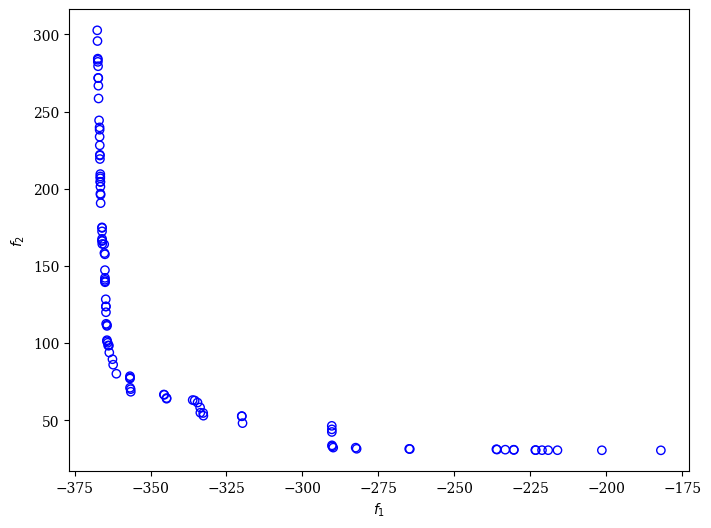

In [48]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="b")
plot.show()

## Multi-Criteria Decision Making (MCDM)

Compromise programming

In [17]:
weights = np.array([0.5, 0.5]) # Equal weights for both objectives
decomp = ASF()
F = res.F  # This gets the objective values of solutions in the Pareto front

# Applying Min-Max scaling
scaler = MinMaxScaler()
F_scaled = scaler.fit_transform(F)

I = decomp(F_scaled, weights).argmin()
print(I, F_scaled[I])

22 [0.12302047 0.12285534]


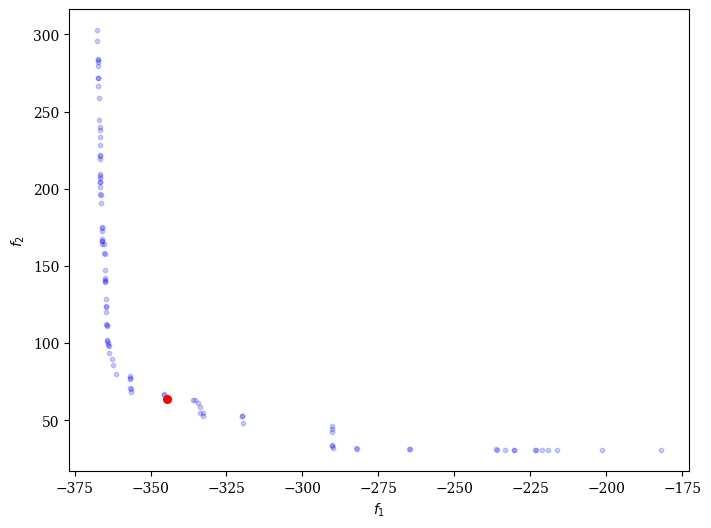

In [18]:
plot = Scatter()
plot.add(F, color="blue", alpha=0.2, s=10)
plot.add(F[I], color="red", s=30)
plot.do()
plot.show()

In [19]:
# Get the selected solution parameters
best_solution_params = res.X[I]

# Extract individual parameters
w1, v1 = best_solution_params
w2 = 1 - w1
v2 = 1 - v1

print(w1, w2, v1, v2)

0.004391480872185376 0.9956085191278147 0.9430111530849734 0.05698884691502659


Final output of our pipeline

In [20]:
# scoring and ranking
df_ranked_ads_final = ad_scoring(df_ads, w1, w2)
df_ranked_moderators_clean_final = moderator_scoring(df_moderator_clean, v1, v2)
df_ranked_moderators_anomaly_final = moderator_scoring(df_moderator_anomaly, v1, v2)
df_ranked_moderators_final = pd.concat([df_ranked_moderators_clean_final, df_ranked_moderators_anomaly_final])

# Get the final output dataset of moderators and their assigned ads
df_matched_final = matching(df_ranked_ads_final, df_ranked_moderators_final)
df_matched_final.to_csv('mod_ads_final_match.csv', index=False)
df_matched_final

,Moderator,Assigned Ad IDs,Accuracy,Handling Time,Total Avg Ad Revenue,Total Punish Num
0,1598527,[1769826449034250],0.676,73,17144.4986,0.0
1,7167613,[],0.556,99,0.0000,0.0
2,1695311101589506,"[1773293685750830, 1771941432681470]",0.975,104,2303.1592,0.0
3,7579980,"[1773281334059040, 1771737651016750, 177291528...",0.667,172,5234.0648,0.0
4,6092503,"[1770501606335480, 1773293685750830, 177329368...",0.757,180,14114.9706,1.0
...,...,...,...,...,...,...
1409,1769313472273426,[],0.486,85868,0.0000,0.0
1410,2379151,[],0.415,85868,0.0000,0.0
1411,2258595,[],0.333,85868,0.0000,0.0
1412,1005827,[],0.894,107285,0.0000,0.0


Extra visualisations

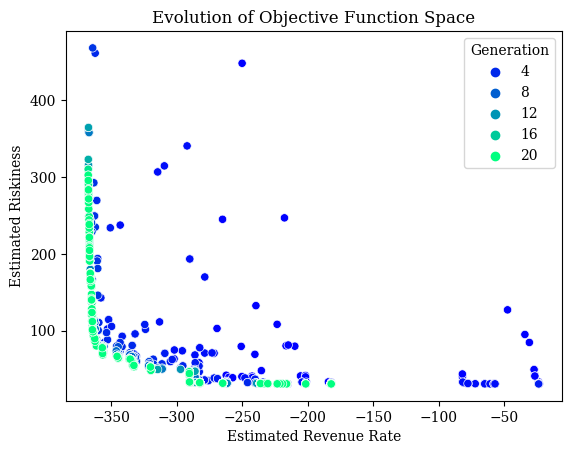

In [44]:
objective_values_history = [gen.pop.get("F") for gen in res.history]
data = []

for i, generation in enumerate(objective_values_history, start=1):
    for individual in generation:
        data.append([i, individual[0], individual[1]])

df = pd.DataFrame(data, columns=['Generation', 'Estimated Revenue Rate', 'Estimated Riskiness'])

sns.scatterplot(x='Estimated Revenue Rate', y='Estimated Riskiness', hue='Generation', data=df, palette='winter')
plt.title('Evolution of Objective Function Space')
plt.xlabel('Estimated Revenue Rate')
plt.ylabel('Estimated Riskiness')
plt.show()

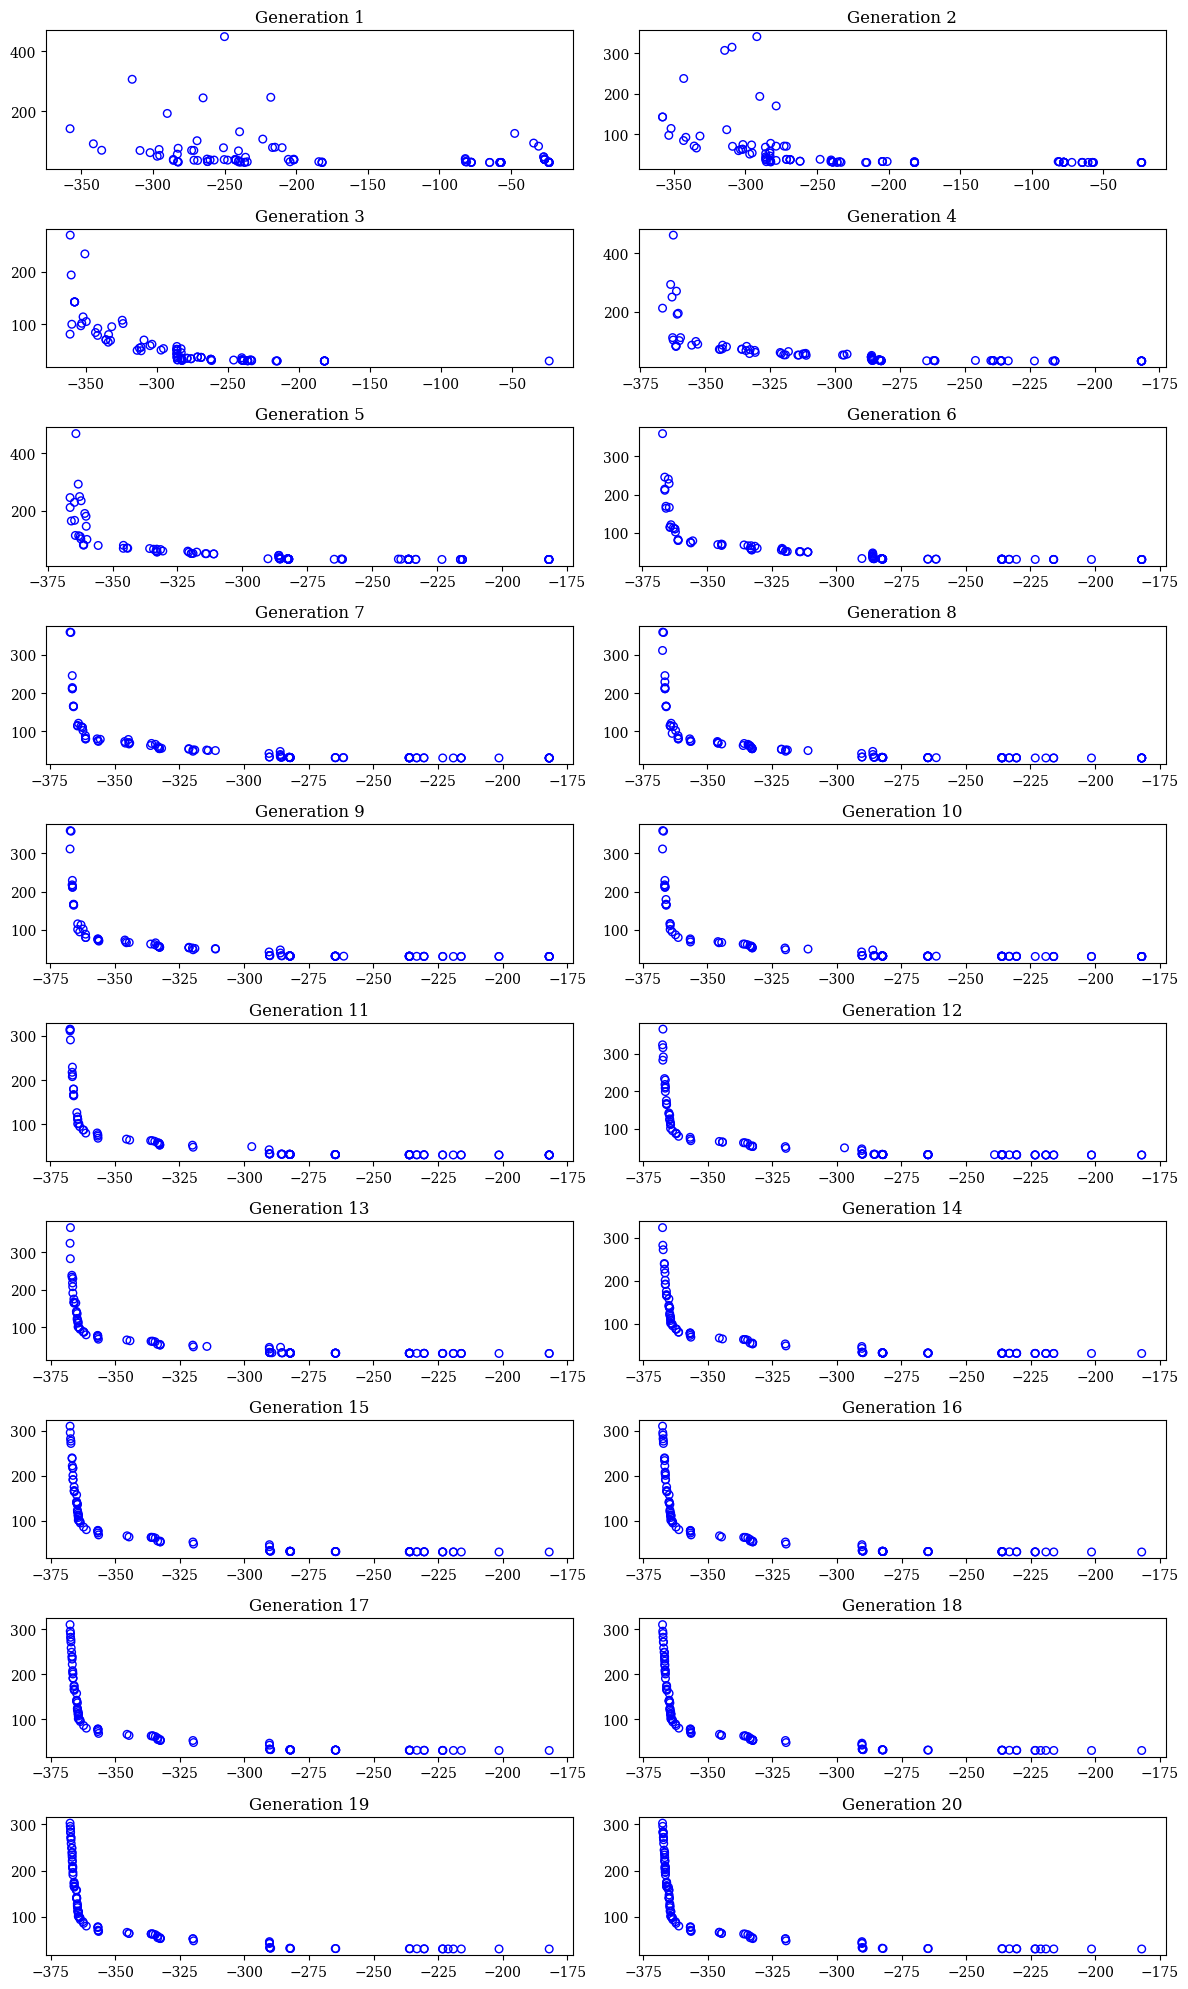

In [47]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(12, 20))
axes_flat = axes.flatten()

for i, (generation, ax) in enumerate(zip(objective_values_history, axes_flat), start=1):
    objectives = generation[:, :2]  
    ax.scatter(objectives[:, 0], objectives[:, 1], s=30, facecolors='none', edgecolors='b')
    ax.set_title(f'Generation {i}')

plt.tight_layout()
plt.show()